# Classification and Forecasting of Water Stress in Tomato Plants using Bioristor Data

## Manuele Bettelli, Filippo Vurro, Riccardo Pecori, Michela Janni,Nicola Coppedè, Andrea Zappettini, Daniele Tessera

## Code Version 1.0

### For more info: daniele.tessera@unicatt.it


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Disable GPU since is not supported by LSTM layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold

from src.util import plotPlant, getLags, getTensors

ModuleNotFoundError: No module named 'src'

In [2]:
binlabels = ['Not Stressed', 'Stressed']

In [3]:
dirpath = os.getcwd()
rawdata = pd.read_csv(os.path.join(dirpath, 'data', 'TOMATO.csv'), sep=';', decimal=',')

In [4]:
rawdata.head()

,Day,Exp,Plant,Species,label,Rds,DIgs,tds,tgs,dRds,dRgs,dtds,dtgs,SRds,SDIgs,Stds,Stgs
0,0.014773,IMEM,A,TOMATO,healthy,0.066654,0.000002,60.524727,22.949897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.034656,IMEM,A,TOMATO,healthy,0.068223,0.000002,61.474049,23.162453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.054543,IMEM,A,TOMATO,healthy,0.070111,0.000002,62.109619,23.373160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.074422,IMEM,A,TOMATO,healthy,0.072093,0.000002,62.563367,23.598323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.094310,IMEM,A,TOMATO,healthy,0.073950,0.000002,62.950393,23.833428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rawdata.drop(['dRds', 'dRgs', 'dtds', 'dtgs', 'SRds', 'SDIgs', 'Stds', 'Stgs'], axis=1, inplace=True)
rawdata.label.astype('category');

In [6]:
rawdata.describe()

,Day,Rds,DIgs,tds,tgs
count,16418.000000,15653.000000,1.565300e+04,15653.000000,15653.000000
mean,12.704003,0.091688,2.682442e-06,102.672955,30.155597
std,7.838070,0.062765,1.652804e-06,74.559961,12.731754
min,0.010829,0.000014,-1.670000e-09,10.053095,5.401225
25%,5.990456,0.043679,1.690000e-06,58.609145,24.704744
50%,11.808032,0.084107,2.750000e-06,87.527876,27.921203
75%,19.543817,0.128386,3.810000e-06,125.511300,31.476546
max,28.331003,0.735517,1.650500e-05,905.024130,176.411750


In [7]:
rawdata[['Exp', 'Plant']].value_counts()

Exp    Plant
ALSIA  A        1292
       B        1292
       C        1292
       D        1292
       E        1292
       G        1292
IMEM   A        1238
       B        1238
       C        1238
       D        1238
       E        1238
       F        1238
       G        1238
dtype: int64

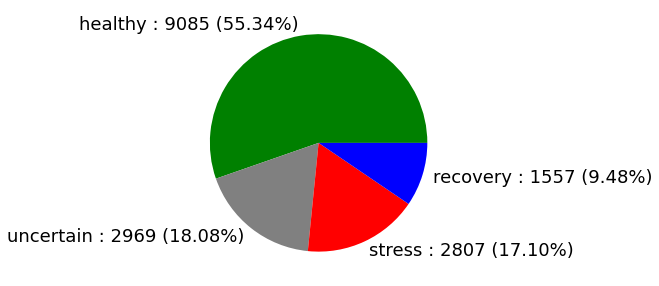

In [8]:
out = rawdata['label'].value_counts()
labs = []
s = sum(out)/100

for i in range(len(out)):
    labs.append(f"{out.index[i]} : {out[i]} ({out[i]/s:.2f}%)")
    
plt.figure(figsize=(10,5) )
plt.pie(out, labels = labs, colors=['green', 'gray', 'red', 'blue'], textprops={'fontsize': 18});
plt.savefig('label_pie.png')

## Data interpolation

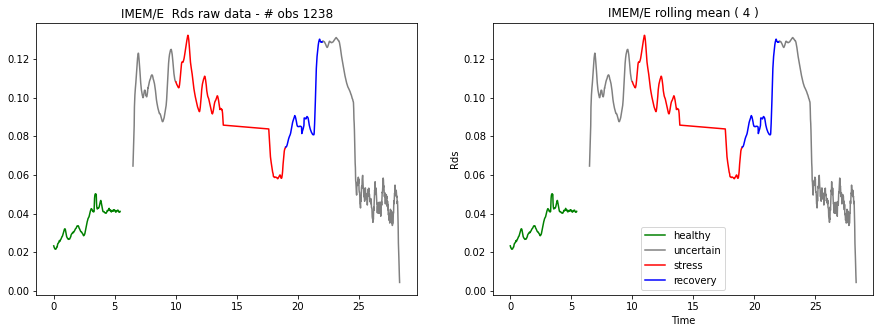

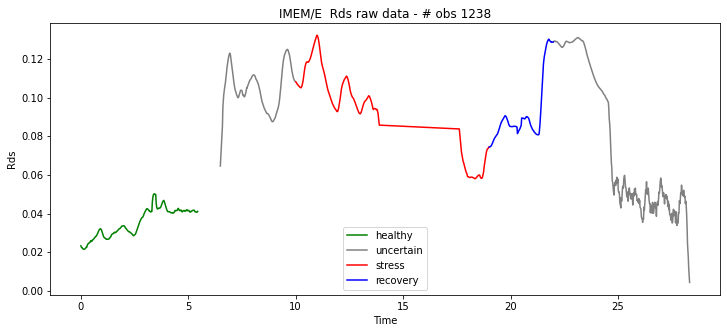

In [9]:
plotPlant(rawdata, 'IMEM', 'E', 'Rds', nsteps=4, figSize=(15,5))
plotPlant(rawdata, 'IMEM', 'E', 'Rds', figSize=(12,5))

In [10]:
for target in ['Rds', 'DIgs', 'tds', 'tgs']:
    nNa = rawdata[target].isna().sum() 
    print(f"Number of N.A. observations for {target:7s} : {nNa:4d} ( {nNa/rawdata.shape[0]*100:.2f}% )")

Number of N.A. observations for Rds     :  765 ( 4.66% )
Number of N.A. observations for DIgs    :  765 ( 4.66% )
Number of N.A. observations for tds     :  765 ( 4.66% )
Number of N.A. observations for tgs     :  765 ( 4.66% )


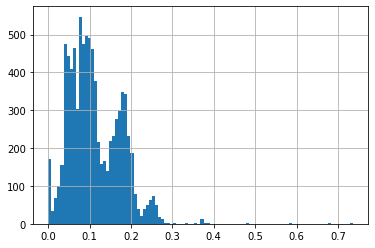

In [11]:
rawdata[rawdata.label=='healthy']['Rds'].hist(bins=100);

In [12]:
dataInterp = rawdata.interpolate(method='from_derivatives')

In [13]:
dataInterp.describe()

,Day,Rds,DIgs,tds,tgs
count,16418.000000,16418.000000,1.641800e+04,16418.000000,16418.000000
mean,12.704003,0.093187,2.658791e-06,101.889569,30.311046
std,7.838070,0.066205,1.652472e-06,73.470747,12.809647
min,0.010829,0.000014,-1.670000e-09,10.053095,5.401225
25%,5.990456,0.044016,1.650000e-06,58.591125,24.743876
50%,11.808032,0.084146,2.730000e-06,86.504940,27.956687
75%,19.543817,0.129811,3.790000e-06,124.623170,31.521486
max,28.331003,0.735517,1.650500e-05,905.024130,176.411750


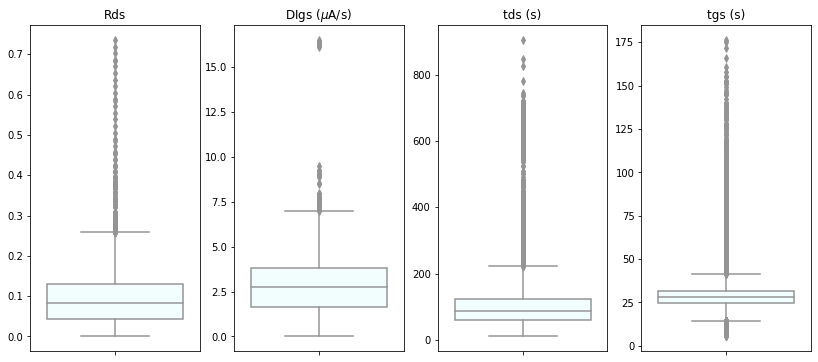

In [14]:
df = dataInterp.copy();

df['DIgs']=1000000*df['DIgs']

selection = ['Rds', 'DIgs','tds', 'tgs']
unit = [None, '$\mu$A/s','s','s']

# selection = ['Rds', tds]

# fig, axes = plt.subplots(1, len(selection))
plt.figure(figsize=(14,6))

for i, col in enumerate(selection):
    plt.subplot(1,len(selection), i+1)
    ax = sns.boxplot(y=df[col], color='azure')
    if unit[i] is not None:
        ax.set_title(f"{col} ({unit[i]})")
    else:
        ax.set_title(f"{col}")
        
    ax.set_ylabel("")

plt.savefig('summary.png')
plt.show();

In [15]:
# FIX unfeasible negative values
dataInterp.DIgs[dataInterp.DIgs<0]=0
dataInterp.describe()
# dataInterp.to_csv('AI_Pecori15min - dati grezzi - interpolated.csv')

<ipython-input-15-00a0b1fe7332>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataInterp.DIgs[dataInterp.DIgs<0]=0


,Day,Rds,DIgs,tds,tgs
count,16418.000000,16418.000000,16418.000000,16418.000000,16418.000000
mean,12.704003,0.093187,0.000003,101.889569,30.311046
std,7.838070,0.066205,0.000002,73.470747,12.809647
min,0.010829,0.000014,0.000000,10.053095,5.401225
25%,5.990456,0.044016,0.000002,58.591125,24.743876
50%,11.808032,0.084146,0.000003,86.504940,27.956687
75%,19.543817,0.129811,0.000004,124.623170,31.521486
max,28.331003,0.735517,0.000017,905.024130,176.411750


### Plot interpolated data

<Figure size 1728x1152 with 0 Axes>

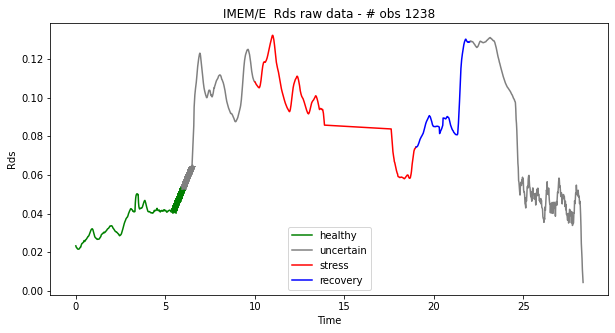

In [16]:
exp = 'IMEM'
plant='E'

plt.figure(figsize=(24,16));

plotPlant(rawdata, exp, plant, 'Rds', dataInterp=dataInterp, figSize=(10,5));
plt.savefig('interpolation.png')
# plotPlant(rawdata, exp, plant, 'tds', dataInterp=dataInterp, figSize=(10,5))
# plotPlant(rawdata, exp, plant, 'tgs', dataInterp=dataInterp, figSize=(10,5))

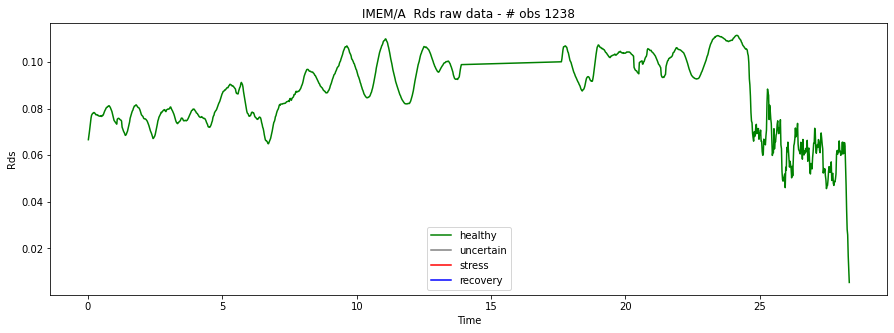

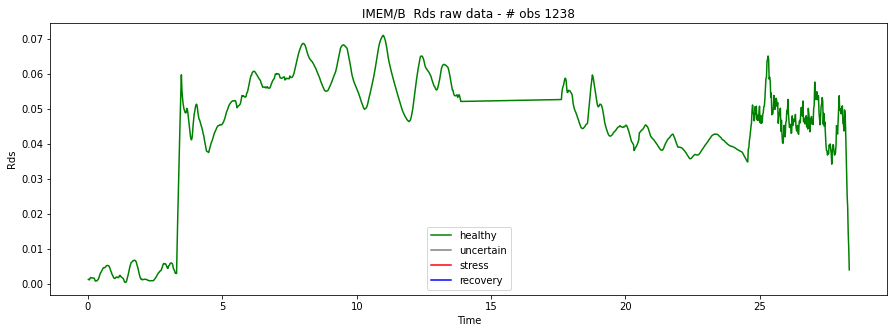

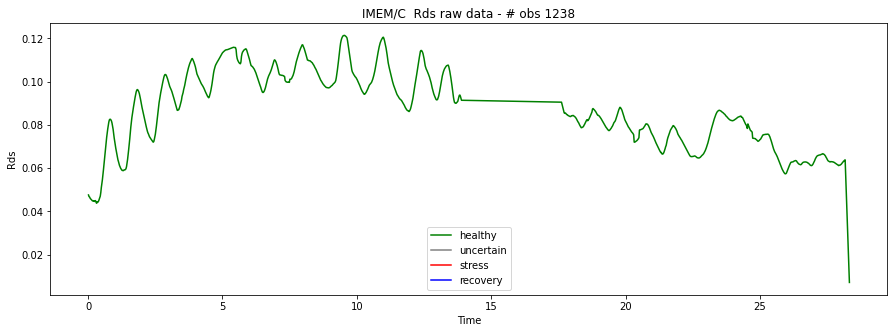

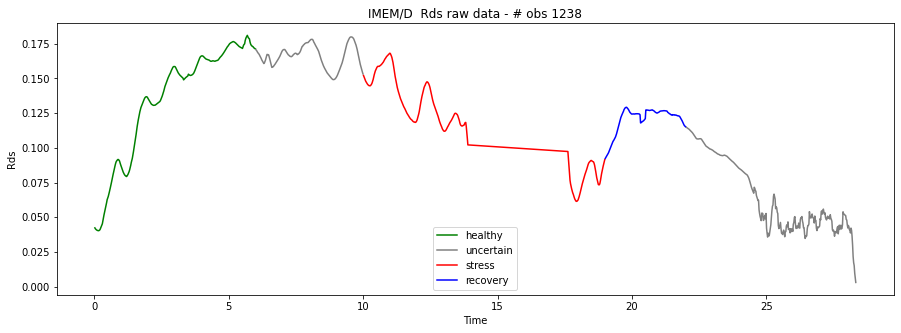

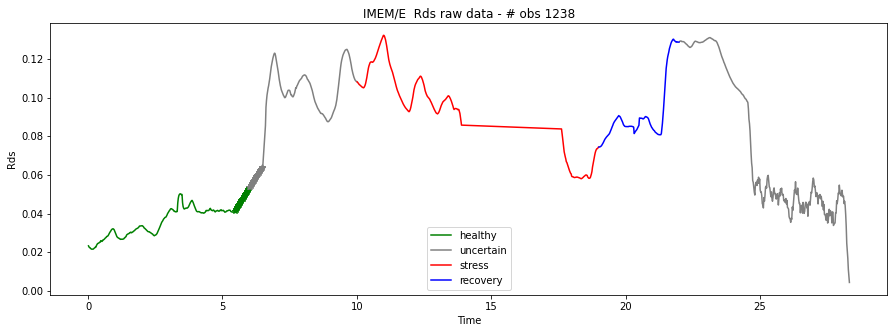

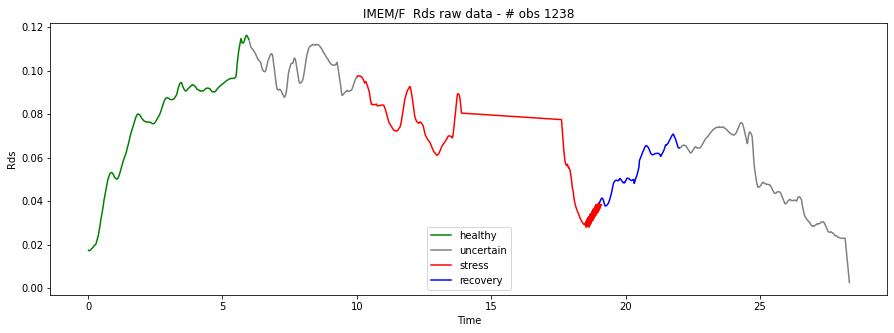

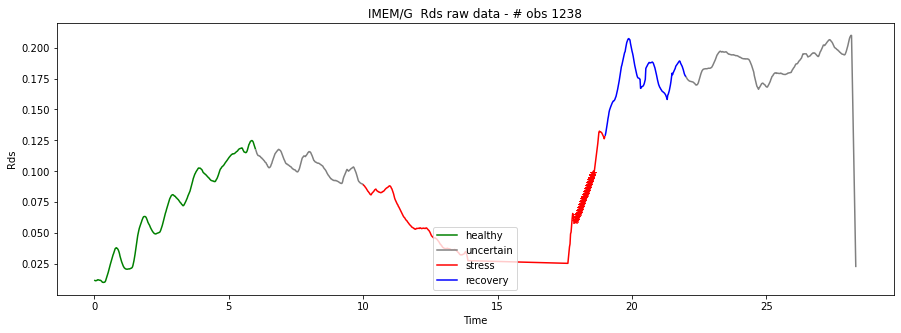

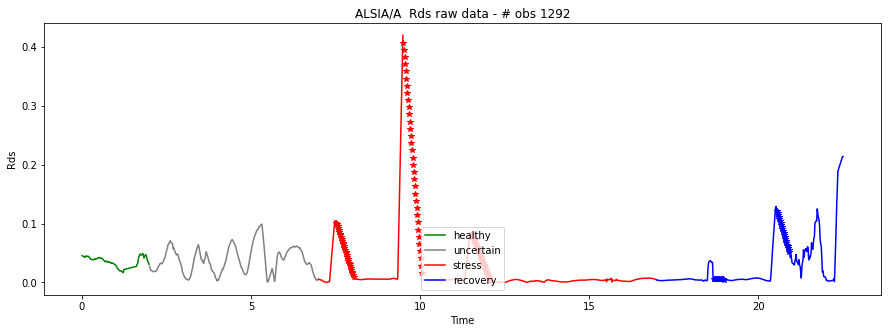

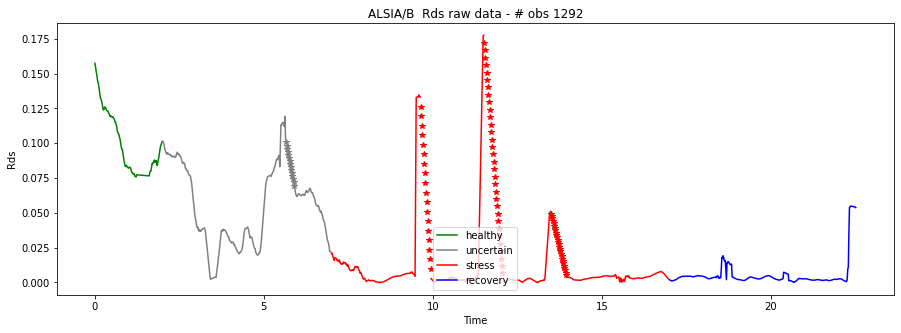

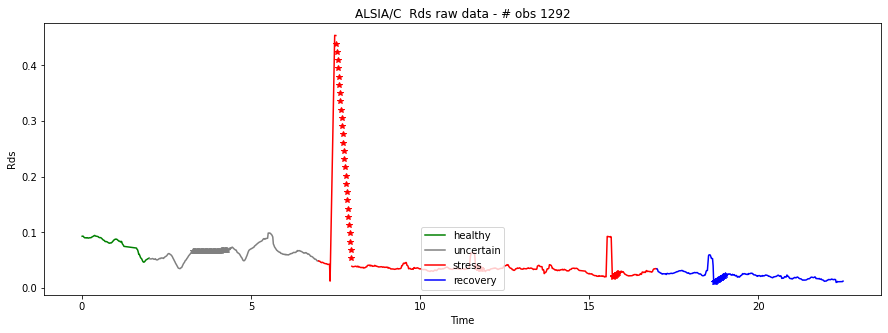

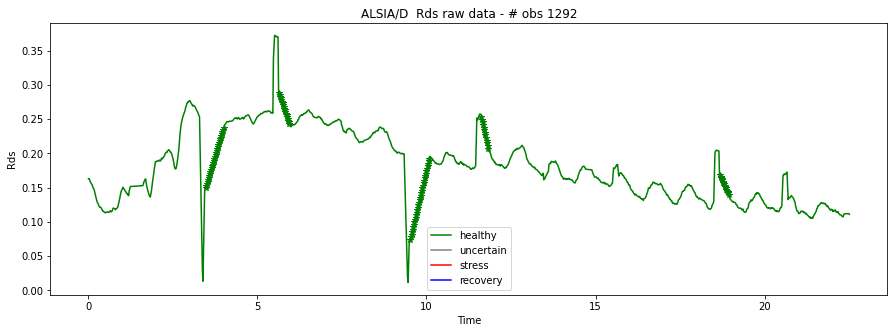

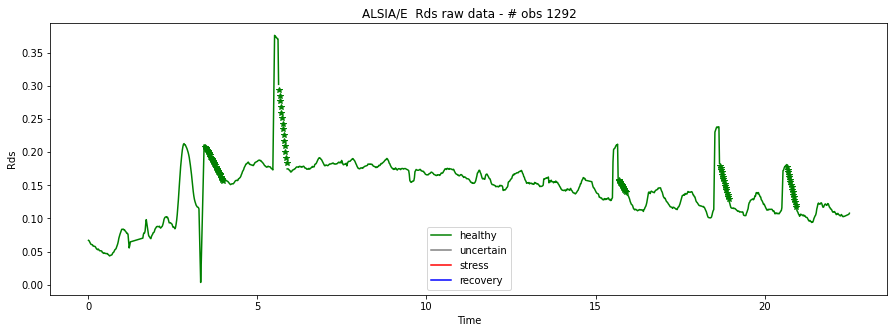

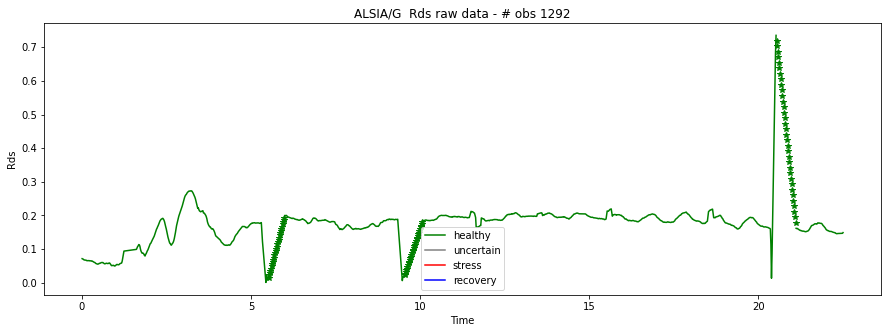

In [17]:
# Plot a parameter for all plants

target='Rds'

for e in rawdata.Exp.unique():
    for p in rawdata.Plant[rawdata.Exp==e].unique():
        plotPlant(rawdata, e, p, target, dataInterp=dataInterp, figSize=(15,5))

## Add target for one-hot enconding

In [18]:
dataInterp['target'] = dataInterp['label'].map({'healthy':0, 'uncertain':1, 'stress':2, 'recovery':3})
dataInterp.target.astype('category')
dataInterp.head()

sorted_labels = ['healthy', 'uncertain', 'stress', 'recover']

### Smoothing data on with a rolling mean (size=smoothWindow)

In [19]:
smoothWindow = 4

data = dataInterp.set_index(['Exp', 'Plant']).sort_index()
data['idx']=pd.NA
for t, gdf in data.groupby(['Exp', 'Plant']):
    data.loc[t, 'idx'] = np.arange(gdf.shape[0])
data.reset_index(inplace=True)
data.set_index(['Exp', 'Plant', 'idx'], inplace=True)
data.sort_index()

for c in ('Rds', 'DIgs', 'tds', 'tgs'):
    for t, gds in data.groupby(['Exp', 'Plant']):
        s = gds[c].rolling(smoothWindow).mean()
        data.loc[t,f"s{c}"] = s

for t, gds in data.groupby(['Exp', 'Plant']):
        s = gds['target'].rolling(smoothWindow).max().to_numpy()
        data.loc[t,'starget'] = s

### Plot individual plant/parameter

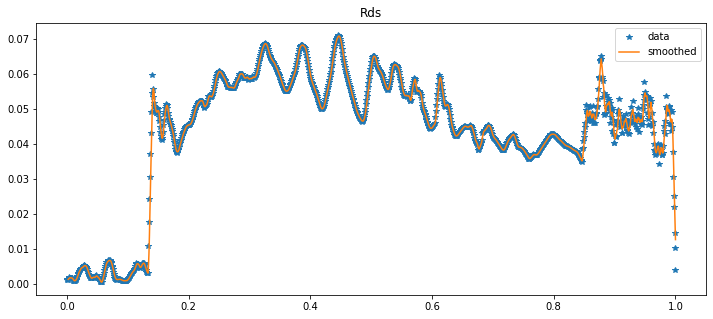

In [20]:
exp = 'IMEM'
plant = 'B'
target = 'Rds'
starget = f"s{target}"

plt.figure(figsize=(12,5))
y = data.loc[exp,plant,:][target]
x = np.linspace(0,1,len(y))
plt.plot(x, y,'*', label='data')
ys = data.loc[exp, plant, :][starget]
x = np.linspace(0,1,len(ys))
plt.plot(x, ys, label='smoothed')
plt.title(target);
plt.legend();

In [21]:
sample = 4
shift = 0
targetCols = ['Rds', 'DIgs', 'tds', 'tgs', 'target', 'sRds', 'sDIgs', 'stds', 'stgs', 'starget']

dhour = pd.DataFrame()

for t, gdf in data.groupby(['Exp','Plant']):
    dhour = dhour.append(gdf[targetCols][shift::sample])

dhour.loc['ALSIA','A'].head()

,Rds,DIgs,tds,tgs,target,sRds,sDIgs,stds,stgs,starget
idx,,,,,,,,,,
0,0.045589,0.000001,62.277342,16.037781,0,NaN,NaN,NaN,NaN,NaN
4,0.043619,0.000001,67.362482,14.888491,0,0.044208,0.000001,65.537782,15.320717,0.0
8,0.044490,0.000001,76.750356,14.420517,0,0.044191,0.000001,73.892083,14.504285,0.0
12,0.043707,0.000001,98.417203,14.297027,0,0.044287,0.000001,86.202022,14.347170,0.0
16,0.038998,0.000001,137.620720,14.415883,0,0.040452,0.000001,127.532720,14.403899,0.0


In [22]:
dhour.dropna(inplace=True)

dhour

Rds          DIgs         tds        tgs  target  \
Exp   Plant idx                                                           
ALSIA A     4     0.043619  1.040000e-06   67.362482  14.888491       0   
            8     0.044490  1.100000e-06   76.750356  14.420517       0   
            12    0.043707  1.110000e-06   98.417203  14.297027       0   
            16    0.038998  1.120000e-06  137.620720  14.415883       0   
            20    0.038100  1.150000e-06  118.467600  14.400891       0   
...                    ...           ...         ...        ...     ...   
IMEM  G     1220  0.198553  1.530000e-06   54.551623  26.541186       1   
            1224  0.205493  1.480000e-06   52.629808  25.638631       1   
            1228  0.209944  1.460000e-06   51.233936  24.950834       1   
            1232  0.140186  9.790000e-07   50.360868  24.733251       1   
            1236  0.046414  3.310000e-07   48.906925  24.551891       1   

                      sRds         sDIgs        stds       stgs  starget  
Exp   Plant idx                                                           
ALSIA A     4     0.044208  1.027500e-06   65.537782  15.320717      0.0  
            8     0.044191  1.080000e-06   73.892083  14.504285      0.0  
            12    0.044287  1.097500e-06   86.202022  14.347170      0.0  
            16    0.040452  1.112500e-06  127.532720  14.403899      0.0  
            20    0.038784  1.145000e-06  128.201122  14.393821      0.0  
...                    ...           ...         ...        ...      ...  
IMEM  G     1220  0.196436  1.550000e-06   54.847223  26.673261      1.0  
            1224  0.202590  1.497500e-06   53.362164  26.005378      1.0  
            1228  0.208727  1.465000e-06   51.681850  25.150334      1.0  
            1232  0.175097  1.222250e-06   50.757825  24.804598      1.0  
            1236  0.081606  5.745000e-07   49.407965  24.616327      1.0  

[4095 rows x 10 columns]

### Getting a dataframe with selected lagged measures

In [23]:
nlag = 9
target = ['Rds', 'DIgs', 'tds', 'tgs', 'target']

In [24]:
data_lagged = getLags(dhour, target, nlag)

In [25]:
data_lagged.columns

Index(['Rds_8', 'Rds_7', 'Rds_6', 'Rds_5', 'Rds_4', 'Rds_3', 'Rds_2', 'Rds_1',
       'Rds_0', 'DIgs_8', 'DIgs_7', 'DIgs_6', 'DIgs_5', 'DIgs_4', 'DIgs_3',
       'DIgs_2', 'DIgs_1', 'DIgs_0', 'tds_8', 'tds_7', 'tds_6', 'tds_5',
       'tds_4', 'tds_3', 'tds_2', 'tds_1', 'tds_0', 'tgs_8', 'tgs_7', 'tgs_6',
       'tgs_5', 'tgs_4', 'tgs_3', 'tgs_2', 'tgs_1', 'tgs_0', 'target_8',
       'target_7', 'target_6', 'target_5', 'target_4', 'target_3', 'target_2',
       'target_1', 'target_0', 'target'],
      dtype='object')

### Select interesting lags

In [26]:
ok_cols = []

for c in ['Rds', 'DIgs', 'tds', 'tgs']:
    for lag in range(0, nlag, 3):
        ok_cols.append(f"{c}_{lag}")

ok_cols.append('target_0')
        
data_lagged = data_lagged[ok_cols]
data_lagged.rename(columns={'target_0':'target'}, inplace=True)

data_lagged

Rds_0     Rds_3     Rds_6        DIgs_0    DIgs_3  \
Exp   Plant idx                                                          
ALSIA A     40    0.039871  0.039349  0.043707  1.460000e-06  0.000001   
            44    0.035122  0.041151  0.038998  1.390000e-06  0.000001   
            48    0.034494  0.042195  0.038100  1.340000e-06  0.000001   
            52    0.034720  0.039871  0.039349  1.410000e-06  0.000001   
            56    0.033246  0.035122  0.041151  1.310000e-06  0.000001   
...                    ...       ...       ...           ...       ...   
IMEM  G     1220  0.194177  0.197585  0.204563  1.580000e-06  0.000002   
            1224  0.198553  0.196062  0.200942  1.530000e-06  0.000002   
            1228  0.205493  0.194675  0.199218  1.480000e-06  0.000002   
            1232  0.209944  0.194177  0.197585  1.460000e-06  0.000002   
            1236  0.140186  0.198553  0.196062  9.790000e-07  0.000002   

                    DIgs_6       tds_0       tds_3       tds_6      tgs_0  \
Exp   Plant idx                                                             
ALSIA A     40    0.000001  159.703300   97.135855   98.417203  14.106836   
            44    0.000001  172.622490  137.489770  137.620720  14.261547   
            48    0.000001  196.623480  156.115450  118.467600  14.628703   
            52    0.000001  203.861620  159.703300   97.135855  14.832061   
            56    0.000001  207.536150  172.622490  137.489770  15.306873   
...                    ...         ...         ...         ...        ...   
IMEM  G     1220  0.000002   54.824263   51.172670   49.959330  26.666831   
            1224  0.000002   54.551623   52.641937   49.778834  26.541186   
            1228  0.000002   52.629808   53.759028   50.073728  25.638631   
            1232  0.000002   51.233936   54.824263   51.172670  24.950834   
            1236  0.000002   50.360868   54.551623   52.641937  24.733251   

                      tgs_3      tgs_6  target  
Exp   Plant idx                                 
ALSIA A     40    14.538171  14.297027     0.0  
            44    14.675321  14.415883     0.0  
            48    14.321565  14.400891     0.0  
            52    14.106836  14.538171     0.0  
            56    14.261547  14.675321     0.0  
...                     ...        ...     ...  
IMEM  G     1220  25.362393  24.357466     1.0  
            1224  25.911547  24.728637     1.0  
            1228  26.313139  24.995058     1.0  
            1232  26.666831  25.362393     1.0  
            1236  26.541186  25.911547     1.0  

[3978 rows x 13 columns]

# Neural Network models

In [27]:
nepochs = 300
patience = 10

## RNN 4 states

In [28]:
nsteps = 1
test_th = 0.2

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [29]:
nLSTMs = 20

model = tf.keras.Sequential()
model.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
model.add(layers.Dense(Y.shape[1], activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',  metrics =['accuracy', 'categorical_accuracy',
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall() ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________


In [30]:
y_integers = np.argmax(Y, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
print('balanced class weights:', weights*2)
weights= {0:1,1:1,2:4,3:1}
print('actual class weights:',weights)

balanced class weights: [0.92553688 2.69727891 2.80807365 5.18979058]
actual class weights: {0: 1, 1: 1, 2: 4, 3: 1}


In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

# model.fit(x_train, y_train, class_weight=weights, epochs=nepochs, batch_size=100, verbose=1)
# model.fit(x_train, y_train, class_weight=weights, epochs=nepochs,  verbose=1)
model_hist = model.fit(x_train, y_train, class_weight=weights, epochs=nepochs, verbose=1, callbacks=[callback])

Epoch 1/300
100/100 [==============================] - 6s 22ms/step - loss: 1.8599 - accuracy: 0.2093 - categorical_accuracy: 0.2093 - precision: 0.4167 - recall: 0.0363
Epoch 2/300
100/100 [==============================] - 2s 23ms/step - loss: 1.5725 - accuracy: 0.5460 - categorical_accuracy: 0.5460 - precision: 0.6452 - recall: 0.2528
Epoch 3/300
100/100 [==============================] - 2s 23ms/step - loss: 1.4844 - accuracy: 0.5712 - categorical_accuracy: 0.5712 - precision: 0.6350 - recall: 0.3544
Epoch 4/300
100/100 [==============================] - 2s 23ms/step - loss: 1.4587 - accuracy: 0.5801 - categorical_accuracy: 0.5801 - precision: 0.6297 - recall: 0.3887
Epoch 5/300
100/100 [==============================] - 2s 23ms/step - loss: 1.4387 - accuracy: 0.5706 - categorical_accuracy: 0.5706 - precision: 0.6075 - recall: 0.3849
Epoch 6/300
100/100 [==============================] - 2s 23ms/step - loss: 1.4181 - accuracy: 0.5640 - categorical_accuracy: 0.5640 - precision: 0.60

In [32]:
yp = model.predict(x_test)
yp_class = np.round(yp)

sorted_labels = ['healty', 'uncertain','stress','recover']

score = model.evaluate(x_test, y_test, verbose=0)

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Accuracy2: {score[2]*100:.2f}%")
print(f"Precision: {score[3]*100:.2f}%")
print(f"Recall:    {score[4]*100:.2f}%")

# print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1)))

cmatrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1))

25/25 [==============================] - 0s 4ms/step
Accuracy:  86.89%
Accuracy2: 86.89%
Precision: 87.72%
Recall:    86.51%


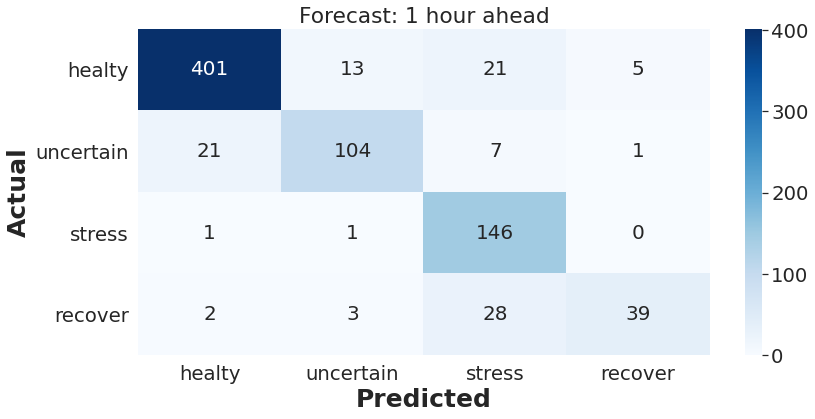

In [33]:
plt.figure(figsize=(12.8, 6))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold');
plt.ylabel('Actual', fontsize = 25, weight='bold');
plt.title(f'Forecast: {nsteps} hour ahead');
# sns.heatmap(cmatrix, annot=True, fmt='d', annot_kws={"fontsize": 16}, cbar=False, xticklabels=sorted_labels, yticklabels=sorted_labels,cmap='Blues');

## RNN binary modeling

In [34]:
classificator = tf.keras.Sequential()
classificator.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator.add(layers.Dense(1, activation='sigmoid'))
classificator.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy',
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall() ])

classificator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1760      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [35]:
(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [36]:
pd.DataFrame(y_train).value_counts()

0.0    2623
1.0     549
dtype: int64

In [37]:
weights={0:1, 1:4}
# weights = {0:1, 1:1}

In [38]:
class_hist = classificator.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, verbose=1, callbacks=[ callback ])
# classificator.save('RNN-binary')

Epoch 1/300
100/100 [==============================] - 5s 23ms/step - loss: 1.0088 - accuracy: 0.6923 - precision_1: 0.3007 - recall_1: 0.5865
Epoch 2/300
100/100 [==============================] - 2s 23ms/step - loss: 0.9064 - accuracy: 0.7878 - precision_1: 0.4117 - recall_1: 0.5264
Epoch 3/300
100/100 [==============================] - 2s 23ms/step - loss: 0.8365 - accuracy: 0.7998 - precision_1: 0.4328 - recall_1: 0.5046
Epoch 4/300
100/100 [==============================] - 2s 23ms/step - loss: 0.8258 - accuracy: 0.8001 - precision_1: 0.4349 - recall_1: 0.5173
Epoch 5/300
100/100 [==============================] - 2s 23ms/step - loss: 0.8119 - accuracy: 0.7967 - precision_1: 0.4277 - recall_1: 0.5173
Epoch 6/300
100/100 [==============================] - 2s 24ms/step - loss: 0.8022 - accuracy: 0.7759 - precision_1: 0.3956 - recall_1: 0.5592
Epoch 7/300
100/100 [==============================] - 2s 23ms/step - loss: 0.7904 - accuracy: 0.7866 - precision_1: 0.4142 - recall_1: 0.5628

In [39]:
yp = classificator.predict(x_test)
yp_predicted_class = np.round(yp)
score = classificator.evaluate(x_test, y_test, verbose=0)

score

25/25 [==============================] - 0s 5ms/step


[0.17088620364665985,
 0.9268600344657898,
 0.7828571200370789,
 0.8726114630699158]

Accuracy:  92.69%
Precision: 78.29%
Recall:    87.26%


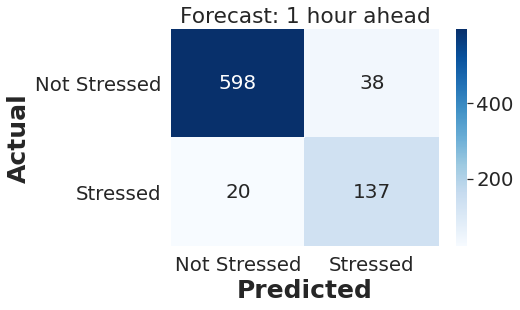

In [40]:
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

cmatrix = confusion_matrix(y_test, yp_predicted_class)

sns.heatmap(cmatrix, annot=True, xticklabels=binlabels, yticklabels=binlabels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold');
plt.ylabel('Actual', fontsize = 25, weight='bold');
plt.title(f'Forecast: {nsteps} hour ahead');

# Varying the number of ahead prediction lag

In [41]:
nsteps=24
nLSTMs = 30

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [42]:
classificator3 = tf.keras.Sequential()
classificator3.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator3.add(layers.Dense(1, activation='sigmoid'))
classificator3.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', 
                        metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
#                        metrics =['accuracy'])

classificator3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                3840      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [43]:
class3_hist = classificator3.fit(x_train, y_train.reshape(-1,1), class_weight={0:1, 1:3}, epochs=nepochs, callbacks= [callback])

Epoch 1/300
92/92 [==============================] - 4s 23ms/step - loss: 0.9036 - accuracy: 0.7275 - precision_2: 0.3371 - recall_2: 0.4233
Epoch 2/300
92/92 [==============================] - 2s 23ms/step - loss: 0.8392 - accuracy: 0.8018 - precision_2: 0.4823 - recall_2: 0.3369
Epoch 3/300
92/92 [==============================] - 2s 23ms/step - loss: 0.8208 - accuracy: 0.7940 - precision_2: 0.4606 - recall_2: 0.3810
Epoch 4/300
92/92 [==============================] - 2s 22ms/step - loss: 0.7949 - accuracy: 0.7950 - precision_2: 0.4650 - recall_2: 0.3986
Epoch 5/300
92/92 [==============================] - 2s 22ms/step - loss: 0.7891 - accuracy: 0.7954 - precision_2: 0.4683 - recall_2: 0.4303
Epoch 6/300
92/92 [==============================] - 2s 22ms/step - loss: 0.7708 - accuracy: 0.7691 - precision_2: 0.4154 - recall_2: 0.4762
Epoch 7/300
92/92 [==============================] - 2s 22ms/step - loss: 0.7492 - accuracy: 0.7688 - precision_2: 0.4170 - recall_2: 0.4921
Epoch 8/300
9

In [44]:
yp = classificator3.predict(x_test)
yp_class = np.round(yp)
score = classificator3.evaluate(x_test, y_test, verbose=0)

23/23 [==============================] - 0s 5ms/step


In [45]:
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

Accuracy:  93.32%
Precision: 77.78%
Recall:    90.65%


In [46]:
print(confusion_matrix(y_test, yp_class))

[[559  36]
 [ 13 126]]


In [47]:
nsteps=24
nLSTMs = 15

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)


In [48]:
x_train.shape, y_train.shape


((2932, 12), (2932,))

In [49]:
classificator4 = tf.keras.Sequential()
classificator4.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
classificator4.add(layers.Dense(1, activation='sigmoid'))
classificator4.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', 
                       metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])

classificator4.summary()
class4_hist = classificator4.fit(x_train, y_train.reshape(-1,1), epochs=300, callbacks=[callback])
yp = classificator4.predict(x_test)
yp_class = np.round(yp)
score = classificator4.evaluate(x_test, y_test, verbose=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15)                1020      
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
92/92 [==============================] - 4s 24ms/step - loss: 0.5872 - accuracy: 0.7790 - precision_3: 0.2516 - recall_3: 0.0683
Epoch 2/300
92/92 [==============================] - 2s 23ms/step - loss: 0.4573 - accuracy: 0.8083 - precision_3: 0.5372 - recall_3: 0.1138
Epoch 3/300
92/92 [==============================] - 2s 23ms/step - loss: 0.4287 - accuracy: 0.8186 - precision_3: 0.5899 - recall_3: 0.2242
Epoch 4/300
92/92 [======

In [50]:
# print(f"Accuracy {score[1]*100:.2f}%")
print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")

Accuracy:  93.32%
Precision: 79.86%
Recall:    85.19%


In [51]:
print(confusion_matrix(y_test, yp_class))

[[570  29]
 [ 20 115]]


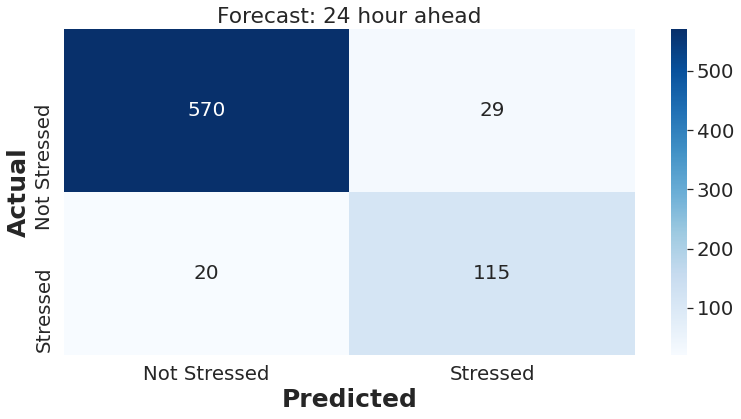

In [52]:
cmatrix = confusion_matrix(y_test, yp_class)

plt.figure(figsize=(12.8, 6))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=binlabels, yticklabels=binlabels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 25, weight='bold');
plt.ylabel('Actual', fontsize = 25, weight='bold');
plt.title(f'Forecast: {nsteps} hour ahead');

plt.savefig('RNN-binary-48h-cmatrix.png')

In [53]:
cmatrix

array([[570,  29],
       [ 20, 115]])

### 24 hours forcasting on four states

In [54]:
nsteps=24
nLSTMs = 30

X, Y, Y2 = getTensors(data_lagged, 'target', nsteps)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=test_th, shuffle=True)
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [55]:
model24h = tf.keras.Sequential()
model24h.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
model24h.add(layers.Dense(Y.shape[1], activation='softmax'))
model24h.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', 
                 metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
model24h.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30)                3840      
                                                                 
 dense_4 (Dense)             (None, 4)                 124       
                                                                 
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


In [56]:
weights= {0:1,1:1,2:4,3:1}

model24h_hist = model24h.fit(x_train, y_train, class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=1)

Epoch 1/300
92/92 [==============================] - 4s 23ms/step - loss: 1.9383 - accuracy: 0.1900 - precision_4: 0.3419 - recall_4: 0.0409
Epoch 2/300
92/92 [==============================] - 2s 23ms/step - loss: 1.6394 - accuracy: 0.4212 - precision_4: 0.4926 - recall_4: 0.1702
Epoch 3/300
92/92 [==============================] - 3s 29ms/step - loss: 1.5532 - accuracy: 0.4659 - precision_4: 0.5097 - recall_4: 0.2428
Epoch 4/300
92/92 [==============================] - 2s 22ms/step - loss: 1.5291 - accuracy: 0.4925 - precision_4: 0.5381 - recall_4: 0.2868
Epoch 5/300
92/92 [==============================] - 2s 22ms/step - loss: 1.4840 - accuracy: 0.4956 - precision_4: 0.5380 - recall_4: 0.2967
Epoch 6/300
92/92 [==============================] - 2s 23ms/step - loss: 1.4756 - accuracy: 0.5130 - precision_4: 0.5377 - recall_4: 0.3114
Epoch 7/300
92/92 [==============================] - 2s 23ms/step - loss: 1.4627 - accuracy: 0.5218 - precision_4: 0.5361 - recall_4: 0.3315
Epoch 8/300
9

In [57]:
yp = model24h.predict(x_test)
yp_class = np.round(yp)
score = model24h.evaluate(x_test, y_test, verbose=0)
cmatrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yp_class, axis=1))

# print(f"Accuracy {score[1]*100:.2f}%")

f1 = 2 *(score[2]*score[3]) / (score[3]+score[3])

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")
print(f"Recall:    {f1*100:.2f}%")

23/23 [==============================] - 0s 4ms/step
Accuracy:  90.05%
Precision: 90.41%
Recall:    89.92%
Recall:    90.41%


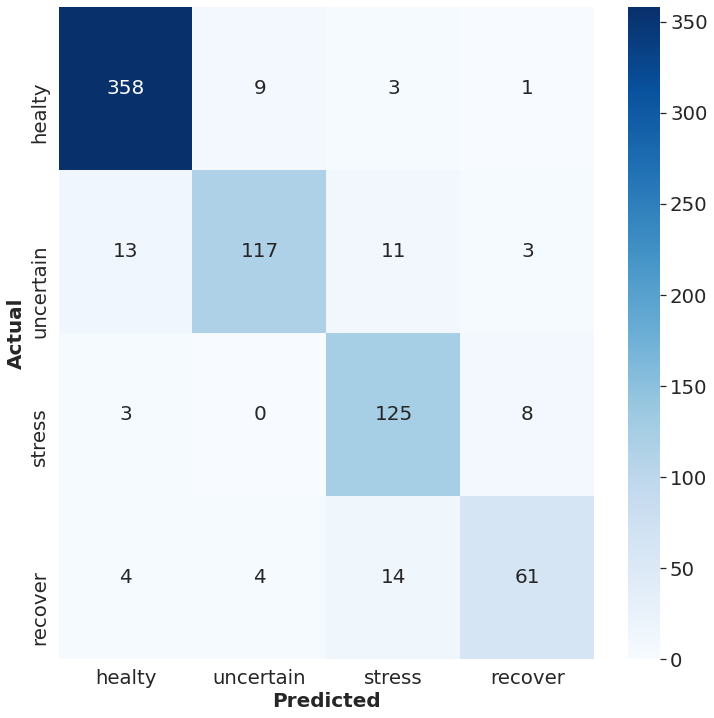

In [58]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.8)
sns.heatmap(cmatrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, annot_kws={"size": 20}, cmap="Blues", fmt="g")
plt.xlabel('Predicted', fontsize = 20, weight='bold')
plt.ylabel('Actual', fontsize = 20, weight='bold')
# plt.title(f'Forecast: {nsteps} hour ahead')
plt.savefig('RNN-4states-24h-cmatrix.png')

In [59]:
plt.savefig('RNN-4states-24h-cmatrix.png');

<Figure size 432x288 with 0 Axes>

### KFold cross validation

In [60]:
kf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
# kf = KFold(n_splits = 5, random_state = 7, shuffle = True)

In [61]:
weights= {0:1,1:1,2:4,3:1}

scores4 = list()
fold_id=1

for train, test in kf.split(X, Y2):
    x_train = X[train,]
    y_train = Y[train,]
    x_test = X[test,]
    y_test = Y[test,]
    
    sc = StandardScaler()
    sc.fit(x_train)

    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    
    print(f"\t processing fold {fold_id}")
    
    model24hf = tf.keras.Sequential()
    model24hf.add(layers.LSTM(nLSTMs, activation='relu', input_shape=(X.shape[1], 1)))
    model24hf.add(layers.Dense(Y.shape[1], activation='softmax'))
    model24hf.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', 
                 metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
    

    model24h_hist = model24hf.fit(x_train, y_train, class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=0)
    
    yp = model24hf.predict(x_test, verbose=0)
    yp_class = np.round(yp)
    score = model24hf.evaluate(x_test, y_test, verbose=0)


    
    scores4.append( (score, model24hf, class_hist))
    
    fold_id = fold_id + 1
    
print('\t done')

	 processing fold 1
	 processing fold 2
	 processing fold 3
	 processing fold 4
	 processing fold 5
	 done


In [62]:
metric = ('accuracy', 'precison', 'recall','f-measure')

for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores4 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores4 ]

print(f"{metric[3]:10} {np.mean(f1)}  {np.std(f1)}")


accuracy   83.9  8.956
precison   85.33  6.615
recall     82.24  11.85
f-measure  83.64033144856397  9.503080459036418


### 24 hours forcasting (2 states)

In [63]:
nahead = 4*3
test_th = 0.2

nLSTM=20

X, Y, Y2 = getTensors(data_lagged, 'target', nahead)

model24h2 = tf.keras.Sequential()
model24h2.add(layers.LSTM(nLSTM, activation='relu', input_shape=(X.shape[1], 1)))
model24h2.add(layers.Dense(1, activation='sigmoid'))
model24h2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])

model24h2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20)                1760      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [64]:
weights = {0:1, 1:1}

(x_train, x_test, y_train, y_test) = train_test_split(X, Y2, test_size=test_th, shuffle=True)

sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [65]:
class_hist_model24h2 = model24h2.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=1)

Epoch 1/300
96/96 [==============================] - 4s 22ms/step - loss: 0.5877 - accuracy: 0.7677 - precision_10: 0.1262 - recall_10: 0.0468
Epoch 2/300
96/96 [==============================] - 2s 21ms/step - loss: 0.4319 - accuracy: 0.8171 - precision_10: 0.4667 - recall_10: 0.0378
Epoch 3/300
96/96 [==============================] - 2s 21ms/step - loss: 0.4072 - accuracy: 0.8217 - precision_10: 0.5514 - recall_10: 0.1061
Epoch 4/300
96/96 [==============================] - 2s 21ms/step - loss: 0.3953 - accuracy: 0.8227 - precision_10: 0.5461 - recall_10: 0.1493
Epoch 5/300
96/96 [==============================] - 2s 21ms/step - loss: 0.3865 - accuracy: 0.8266 - precision_10: 0.5631 - recall_10: 0.2086
Epoch 6/300
96/96 [==============================] - 2s 21ms/step - loss: 0.3769 - accuracy: 0.8299 - precision_10: 0.5947 - recall_10: 0.2032
Epoch 7/300
96/96 [==============================] - 2s 21ms/step - loss: 0.3692 - accuracy: 0.8332 - precision_10: 0.5935 - recall_10: 0.2626

In [66]:
yp = model24h2.predict(x_test)
yp_predict_class = np.round(yp)
score = model24h2.evaluate(x_test, y_test, verbose=0)

# print(f"Accuracy {score[1]*100:.2f}%")
f1 = 2 *(score[2]*score[3]) / (score[3]+score[3])

print(f"Accuracy:  {score[1]*100:.2f}%")
print(f"Precision: {score[2]*100:.2f}%")
print(f"Recall:    {score[3]*100:.2f}%")
print(f"F1:        {f1*100:.2f}%")


print(confusion_matrix(y_test, yp_predict_class))

24/24 [==============================] - 0s 3ms/step
Accuracy:  92.42%
Precision: 75.56%
Recall:    90.67%
F1:        75.56%
[[571  44]
 [ 14 136]]


### K-Fold cross validation

In [67]:
kf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
# kf = KFold(n_splits = 5, random_state = 7, shuffle = True)

In [ ]:
scores2 = list()

fold_id=1

for train, test in kf.split(X, Y2):
    x_train = X[train,]
    y_train = Y2[train,]
    x_test = X[test,]
    y_test = Y2[test,]
    
    sc = StandardScaler()
    sc.fit(x_train)

    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    
    print(f"\t processing fold {fold_id}")
    
    model24h2f = tf.keras.Sequential()
    model24h2f.add(layers.LSTM(nLSTM, activation='relu', input_shape=(X.shape[1], 1)))
    model24h2f.add(layers.Dense(1, activation='sigmoid'))
    model24h2f.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])
    class_hist = model24h2f.fit(x_train, y_train.reshape(-1,1), class_weight=weights, epochs=nepochs, callbacks=[callback], verbose=0)
    
    yp = model24h2f.predict(x_test, verbose=0)
    yp_predict_class = np.round(yp)
    score = model24h2f.evaluate(x_test, y_test, verbose=0)
    
    scores2.append( (score, model24h2f, class_hist))
    
    fold_id = fold_id + 1
    
print('\t done')

	 processing fold 1
	 processing fold 2
	 processing fold 3
	 processing fold 4


In [ ]:
metric = ('accuracy', 'precison', 'recall','f-measure')

for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores4 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores2 ]

print(f"{metric[3]:10} {np.mean(f1)}  {np.std(f1)}")


In [ ]:
metric = ('accuracy', 'precison', 'recall','f-measure')
for i in (1,2,3):
    l=[ x[0][i]*100 for x in scores2 ] 
    print(f"{metric[i-1]:10} {np.mean(l):.4}  {np.std(l):.4}")

f1 = [ 2*x[0][2]*x[0][3]/(x[0][2]+x[0][3])*100 for x in scores2 ]

print(f"{metric[3]:10} {np.mean(f1):.4}  {np.std(f1):.4}")